In [88]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# main.ipynb

## Initialisation

In [3]:
# Import 

## General packages
import os
import sys
from pathlib import Path
from datetime import datetime
from tqdm import tqdm

## Calculation packages
import numpy as np
import math

## Graph
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
import seaborn as sns

## Images
import imageio.v2 as imageio
from PIL import Image

## OpenPIV
from openpiv import tools, pyprocess, validation, filters, scaling

# GUI
import tkinter as tk
from tkinter import filedialog
from matplotlib.widgets import Slider
from ipywidgets import interact

In [89]:
# Custom
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))
from utils import *
from PIVAnalysis import *

In [5]:
# Get datasets directory
folder_path = Path.cwd() / 'data'

# Function to select file using GUI
def select_file():
    root = tk.Tk()
    root.withdraw()  # Hide the root window
    file_path = filedialog.askopenfilename(
        initialdir=folder_path,
        title="Select file",
        filetypes=(("Image files", "*.png *.jpg *.tif *.tiff *.bmp *gif *webp"), ("All files", "*.*"))
    )
    return file_path

## Step-by-step (example)

In [6]:
# Use the GUI to select a file
selected_file_path = select_file()

if selected_file_path:
    # Read image
    # @DEV, does not take into account .nd2 files, should install pims package
    movie = imageio.imread(selected_file_path)
    print(f'{os.path.basename(selected_file_path)} loaded successfully.')
else:
    print("No file selected.")


20241126_1_NC_4x_R2_beads_75um_up.tif loaded successfully.


### Test movie

In [67]:
# Test movie
# a subset of the original image

X0 = 1 # pixels, x-coordinate of the top-left corner of the subset
Y0 = 900 # pixels, y-coordinate of the top-left corner of the subset
L = 300 # pixels, length of the subset
W = 300 # pixels, width of the subset

test_movie = movie[:, X0:X0+L, Y0:Y0+W]

### Image pre-processing

Text(0.5, 1.0, 'removed mean bg + adjusted contrast')

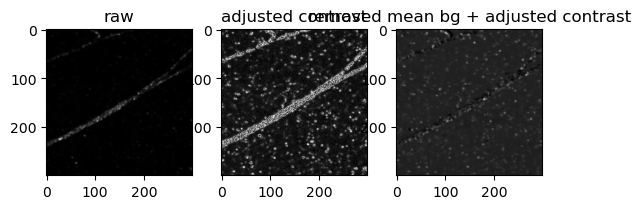

In [82]:
test_frame = test_movie[0,:,:]
background = np.mean(test_movie, axis=0)
test_frame_remove_bg = test_frame / background

fig, ax = plt.subplots(1, 3)
ax[0].imshow(test_frame, cmap='gray')
ax[0].set_title('raw')
ax[1].imshow(adjust_contrast(test_frame), cmap='gray')
ax[1].set_title('adjusted contrast')
ax[2].imshow(adjust_contrast(test_frame_remove_bg), cmap='gray')
ax[2].set_title('removed mean bg + adjusted contrast')



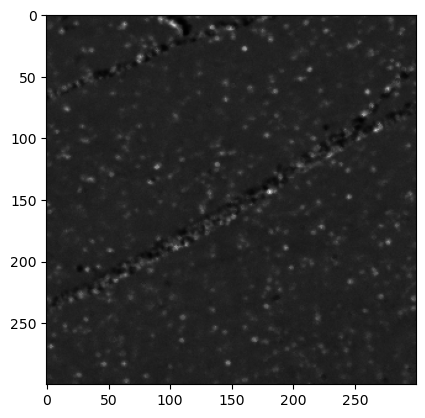

In [90]:
background = np.mean(test_movie, axis=0)
test_movie_rm_bg = remove_background(test_movie, background)
plt.imshow(test_frame_remove_bg, cmap='gray')

### Parameters for PIV

In [93]:
# -- Pre-processing
WINDSIZE:int = 32 # pixels, interrogation window size in frame 't'
SEARCHSIZE:int = math.ceil(WINDSIZE * 1.2)  # pixels, search area size in frame 't+1'
OVERLAP:int = math.ceil(WINDSIZE * 0.5) # pixels, 50% overlap
DT:float = 0.25 # sec, time interval between the two frames
PX2UM:float = 2.75 # pixels/micrometers
# -- Post-processing
S2N_THRESHOLD:float = 1.1 # AU, signal-to-noise threshold to remove false values

### Test

Check if piv_image2image is working
- display t & t+1
- display resulting vectors

In [96]:
frame_a = test_movie[0,:,:]
frame_b = test_movie[1,:,:]

x, y, u, v, filtering_ratio = piv_image2image(
    frame_a, 
    frame_b, 
    WINDSIZE, 
    SEARCHSIZE, 
    OVERLAP, 
    DT, 
    PX2UM, 
    S2N_THRESHOLD)

def update(frame_index):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    if frame_index == 0:
        ax[0].imshow(frame_a, cmap='gray')
    else:
        ax[0].imshow(frame_b, cmap='gray')
    
    ax[1].quiver(x*PX2UM, y*PX2UM, u, v, color='r')
    ax[1].set_aspect('equal')
    plt.show()

interact(update, frame_index=(0, 1))

print(f'Filtering ratio: {filtering_ratio:.2f}')

interactive(children=(IntSlider(value=0, description='frame_index', max=1), Output()), _dom_classes=('widget-i…

Filtering ratio: 0.42


### Effect of parameters

effect of window size on the same image subset
- 16 px
- 32 px
- 64 px
CONSTANT PARAMETERS = overlap stays at 50%

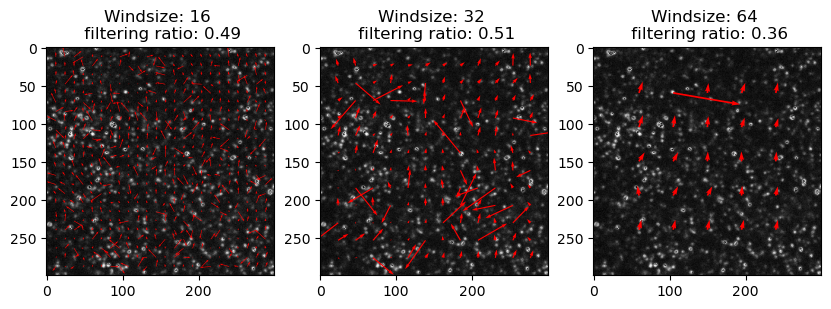

In [13]:
test_windsize = [16, 32, 64]
frame_a = adjust_contrast(test_movie[0,:,:])
frame_b = adjust_contrast(test_movie[1,:,:])

fig, ax = plt.subplots(1, len(test_windsize), figsize=(10, 10))
for index, value in enumerate(test_windsize):
    x, y, u, v, filtering_ratio = piv_image2image(
        frame_a, 
        frame_b, 
        value, 
        math.ceil(value * 1.2), 
        math.ceil(value * 0.5), 
        DT, 
        PX2UM, 
        S2N_THRESHOLD)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x*PX2UM, y*PX2UM, u, v, color='r')
    ax[index].set_title(f'Windsize: {value} \n filtering ratio: {filtering_ratio:.2f}')

plt.show()

effect of frame skipping on the same image subset
- 1:1
- 1:2
- 1:4
- 1:8
CONSTANT PARAMETERS = S2N at 1.05

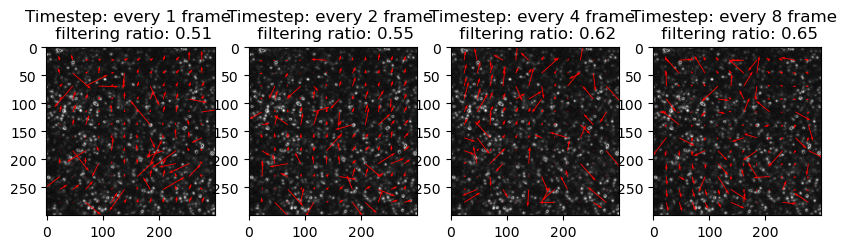

In [14]:
test_dt = [1, 2, 4, 8]
frame_a = adjust_contrast(test_movie[0,:,:])

fig, ax = plt.subplots(1, len(test_dt), figsize=(10, 10))
for index, value in enumerate(test_dt):
    frame_b = adjust_contrast(test_movie[0+value,:,:])

    x, y, u, v, filtering_ratio = piv_image2image(
        frame_a, 
        frame_b, 
        WINDSIZE, 
        SEARCHSIZE, 
        OVERLAP, 
        DT*value, 
        PX2UM, 
        S2N_THRESHOLD)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x*PX2UM, y*PX2UM, u, v, color='r')
    ax[index].set_title(f'Timestep: every {value} frame \n filtering ratio: {filtering_ratio:.2f}')

plt.show()

effect of S2N

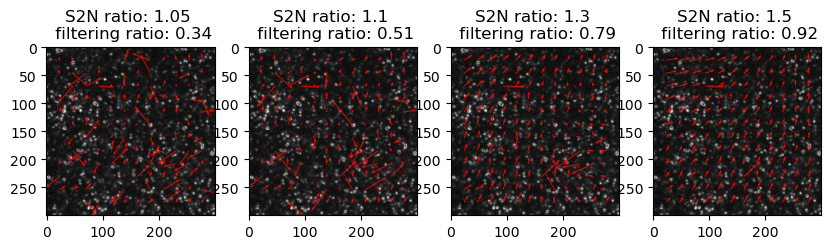

In [15]:
test_s2n = [1.05, 1.1, 1.3, 1.5]
frame_a = adjust_contrast(test_movie[0,:,:])
frame_b = adjust_contrast(test_movie[1,:,:])

fig, ax = plt.subplots(1, len(test_s2n), figsize=(10, 10))
for index, value in enumerate(test_s2n):
    x, y, u, v, filtering_ratio = piv_image2image(
        frame_a, 
        frame_b, 
        WINDSIZE, 
        SEARCHSIZE, 
        OVERLAP, 
        DT, 
        PX2UM, 
        value)

    # Plot
    ax[index].imshow(frame_a, cmap='gray')
    ax[index].quiver(x*PX2UM, y*PX2UM, u, v, color='r')
    ax[index].set_title(f'S2N ratio: {value} \n filtering ratio: {filtering_ratio:.2f}')

plt.show()

combined effect of S2N + timestep

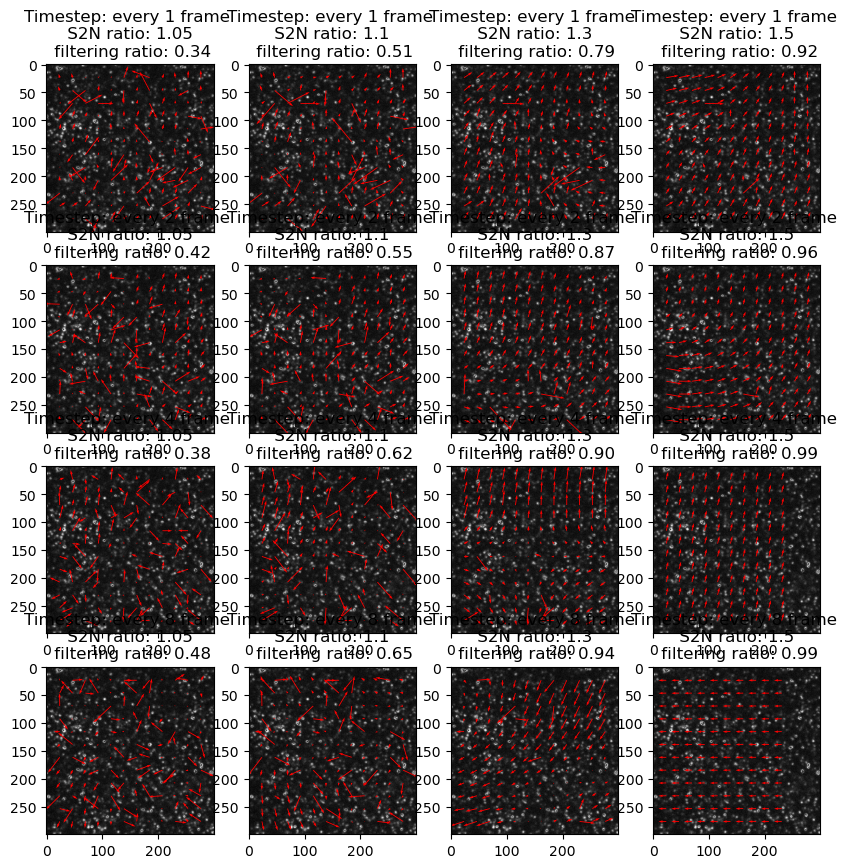

In [16]:
test_dt = [1, 2, 4, 8]
test_s2n = [1.05, 1.1, 1.3, 1.5]
frame_a = adjust_contrast(test_movie[0,:,:])

fig, ax = plt.subplots(len(test_dt), len(test_s2n), figsize=(10, 10))
for index_dt, value_dt in enumerate(test_dt):
    for index_s2n, value_s2n in enumerate(test_s2n):
        frame_b = adjust_contrast(test_movie[0+value_dt,:,:])

        x, y, u, v, filtering_ratio = piv_image2image(
            frame_a, 
            frame_b, 
            WINDSIZE, 
            SEARCHSIZE, 
            OVERLAP, 
            DT*value_dt, 
            PX2UM, 
            value_s2n)

        # Plot
        ax[index_dt, index_s2n].imshow(frame_a, cmap='gray')
        ax[index_dt, index_s2n].quiver(x*PX2UM, y*PX2UM, u, v, color='r')
        ax[index_dt, index_s2n].set_title(f'Timestep: every {value_dt} frame \n S2N ratio: {value_s2n} \n filtering ratio: {filtering_ratio:.2f}')

plt.show()

### Mean values over movie

In [97]:
# Compute entire movie
x, y, u, v = piv_movie(
                test_movie,
                WINDSIZE, 
                SEARCHSIZE, 
                OVERLAP, 
                DT, 
                PX2UM, 
                S2N_THRESHOLD)

100%|██████████| 120/120 [00:13<00:00,  8.82it/s]


compute
- norm
- divergence
- vorticity

  0%|          | 0/119 [00:00<?, ?it/s]

100%|██████████| 119/119 [00:00<00:00, 1564.19it/s]


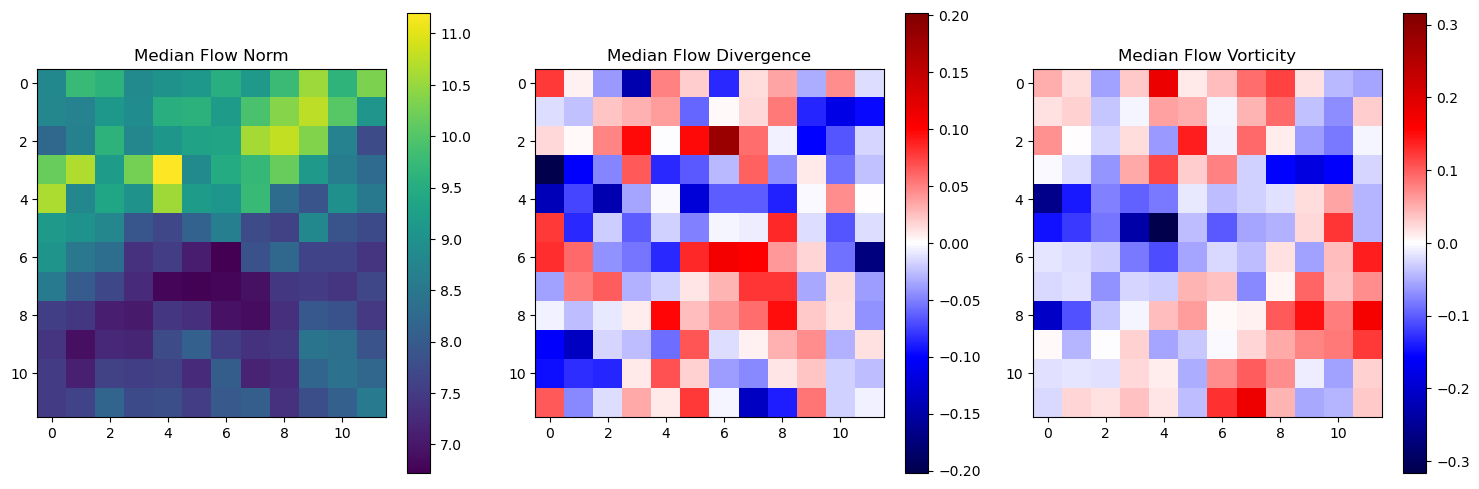

In [98]:
flow_norm, flow_divergence, flow_vorticity = movie_flow_features(x, y, u, v, start=0, end=u.shape[0])

# Median values on 2D map over the course of the movie
fig, ax = plt.subplots(1, 3, figsize=(15,5))

# Compute Median values oves the course of the movie
mean_flow_norm = np.median(flow_norm, axis=0)
mean_flow_divergence = np.median(flow_divergence, axis=0)
mean_flow_vorticity = np.median(flow_vorticity, axis=0)

for index, value in enumerate([mean_flow_norm, mean_flow_divergence, mean_flow_vorticity]):
    if index == 0:
        im = ax[index].imshow(value, cmap='viridis')
        ax[index].set_title(f'Median Flow {["Norm", "Divergence", "Vorticity"][index]}')
        plt.colorbar(im, ax=ax[index])
    else:
        im = ax[index].imshow(value, cmap='seismic', norm=CenteredNorm())
        ax[index].set_title(f'Median Flow {["Norm", "Divergence", "Vorticity"][index]}')
        plt.colorbar(im, ax=ax[index])

plt.tight_layout()
plt.show()

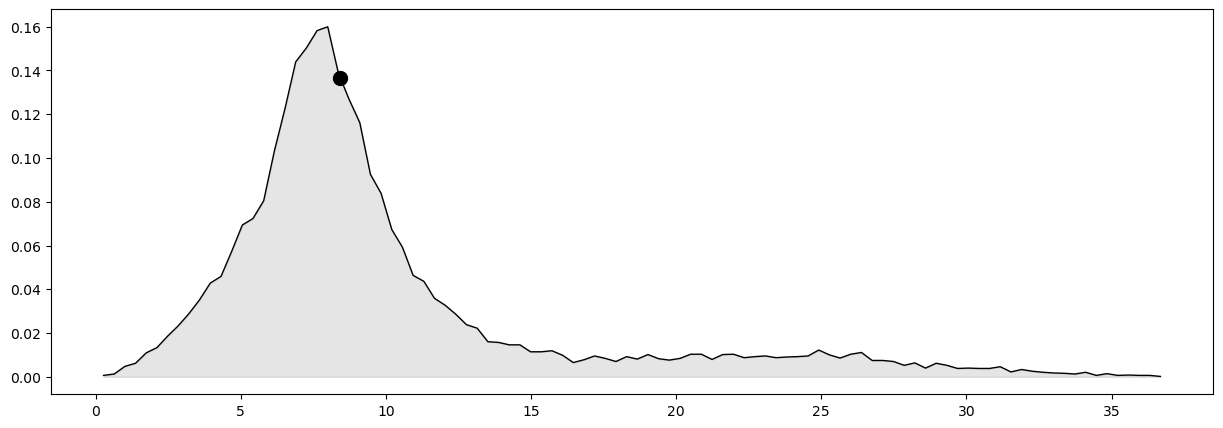

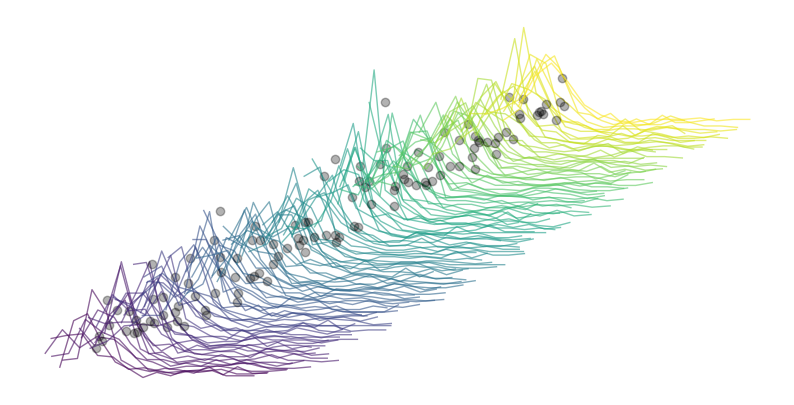

In [99]:
# Speed distributions
u_flatten = flow_norm.flatten()
hist, bin_edges = np.histogram(u_flatten, bins=100, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

plt.figure(figsize=(15,5))
plt.plot(bin_centers, hist, linewidth=1, color='black')
plt.fill_between(bin_centers, hist, color='black', alpha=0.1)
med = np.median(slice_data)
plt.plot(med, np.interp(med, bin_centers, hist), 'o', markersize=10, color='black', alpha=1)
plt.show()

num_slices = flow_norm.shape[0]
colormap = plt.cm.viridis
plt.figure(figsize=(10,5))
# Tracer les histogrammes pour chaque slice le long de l'axe 0
for t in range(num_slices):
    slice_data =flow_norm[t, :, :].flatten()
    color = colormap(t / (num_slices - 1))
    hist, bin_edges = np.histogram(slice_data, bins=15, density=True)

    # Décalage en x et y
    x = bin_edges[:-1] + (t * 0.5)  # Décalage en x
    y = hist + (t * 0.005)  # Décalage en y

    # Tracer la courbe avec des points et colorer l'aire sous la courbe
    plt.plot(x, y, linewidth=1, alpha=0.6, color=color)
    
        # Calculer et afficher la médiane
    med = np.median(slice_data)
    plt.plot(med + (t * 0.5), np.interp(med, x, y), 'o', color='black', alpha=0.3)

plt.axis('off')
plt.show()


Final graph

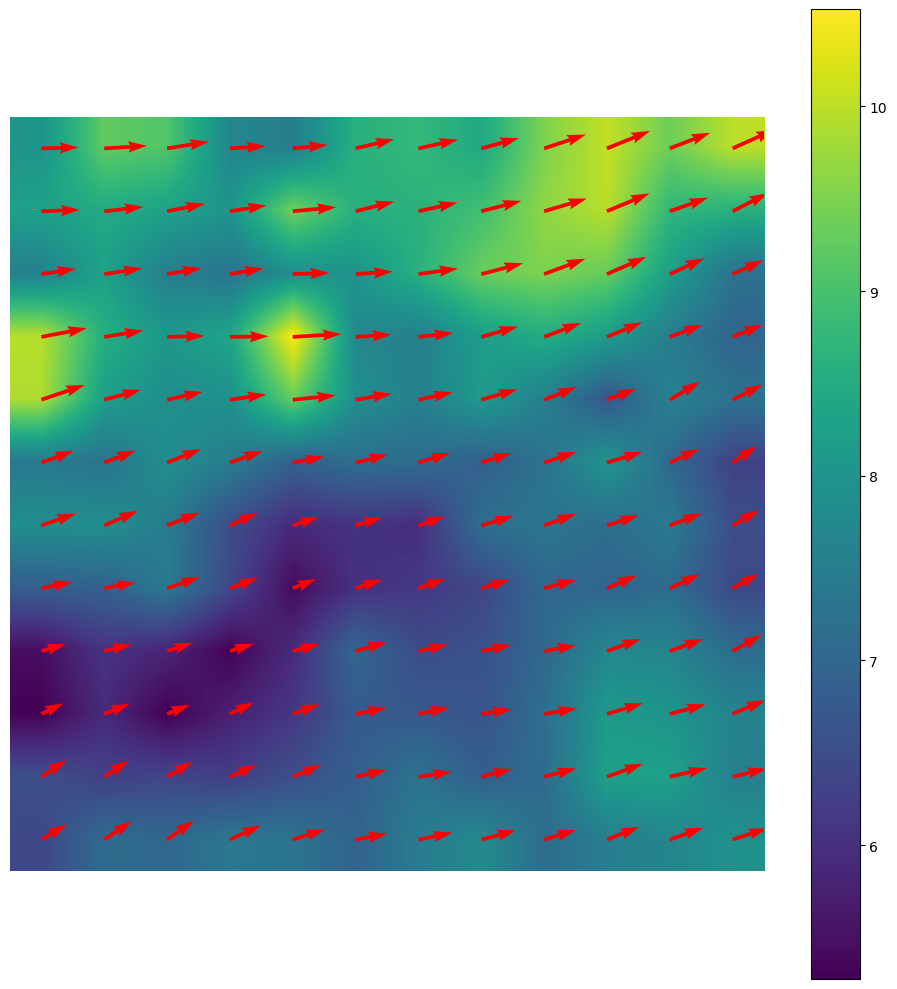

In [101]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
um = np.median(u, axis=0)
vm = np.median(v, axis=0)

im = ax.imshow(np.sqrt(um **2 + vm **2), cmap='viridis', interpolation='bilinear')
ax.quiver(range(u.shape[1]), range(u.shape[2]), um, vm, color='r')
plt.colorbar(im)

plt.tight_layout()
ax.axis('off')
plt.show()

## Final analysis

100%|██████████| 119/119 [00:00<00:00, 1408.00it/s]


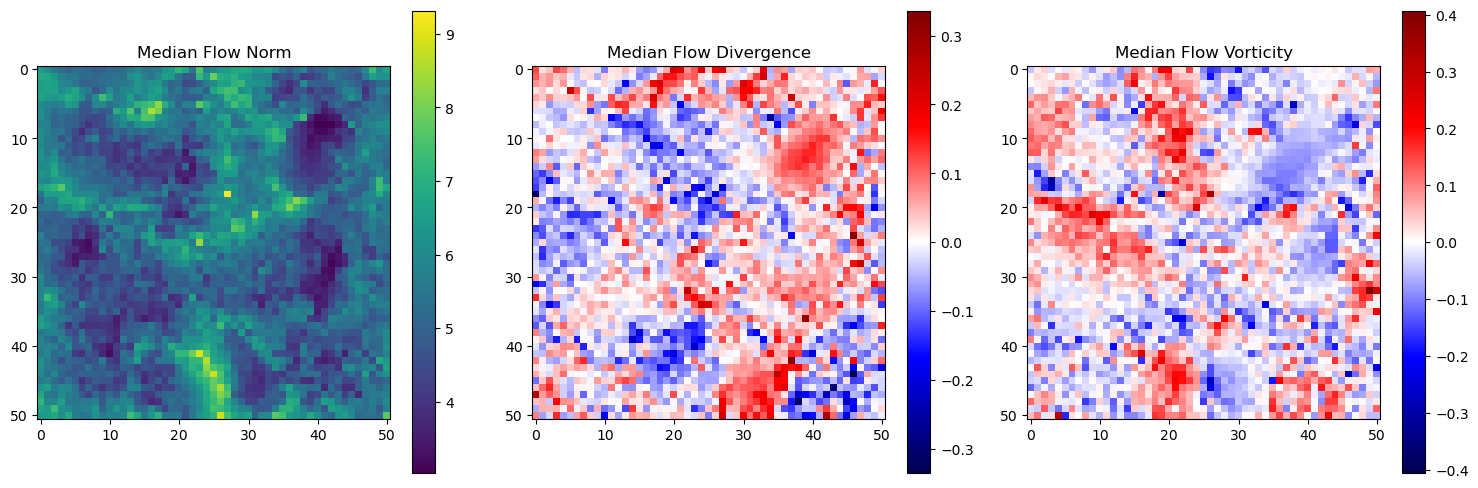

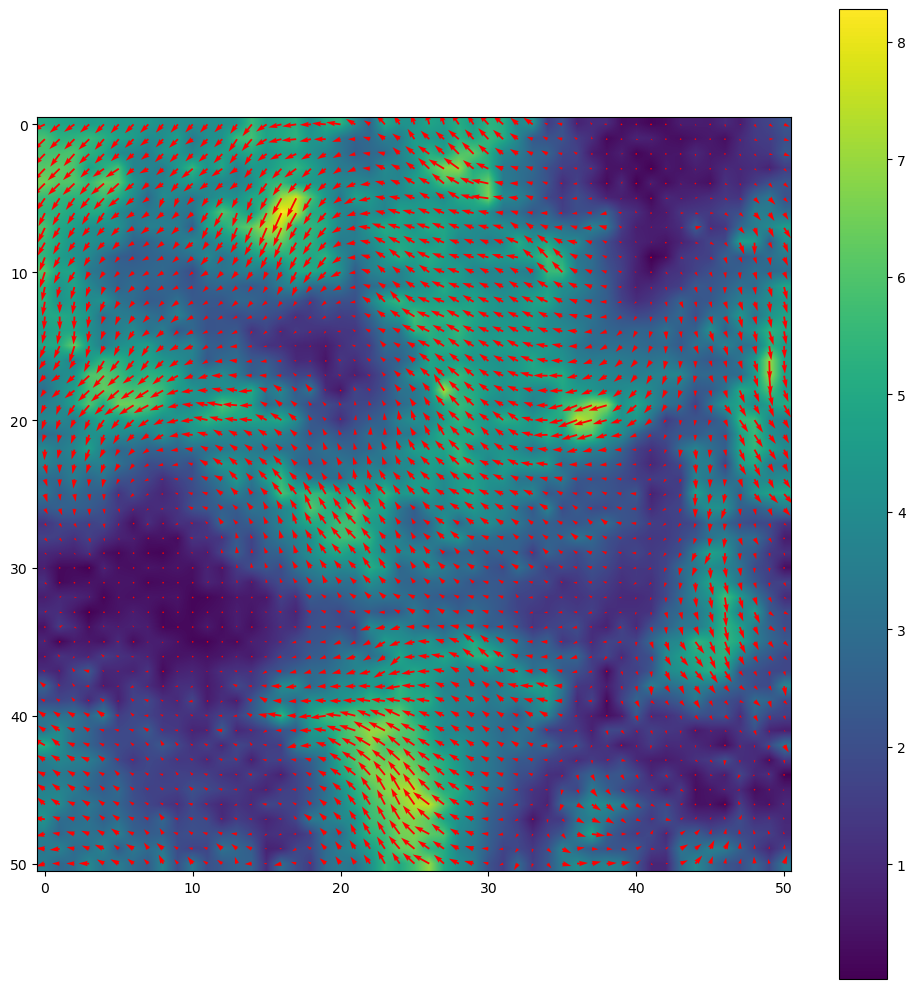

In [102]:
# Movie
selected_file_path = select_file()
movie = imageio.imread(selected_file_path)

# ONLY FOR TESTING
#test_movie = movie[:, :300, :300]
#movie = test_movie

# Optimal parameters
# -- Pre-processing
WINDSIZE:int = 32
SEARCHSIZE:int = math.ceil(WINDSIZE * 1.2) 
OVERLAP:int = math.ceil(WINDSIZE * 0.5)
DT:float = 0.25
PX2UM:float = 2.75
# -- Post-processing
S2N_THRESHOLD:float = 1.1

# Save folder
date_str = datetime.now().strftime("%Y%m%d_%H%M%S")
result_folder = f'results/{os.path.basename(selected_file_path)}_{date_str}'
os.makedirs(result_folder, exist_ok=True)

# Compute & Save movie
x, y, u, v = piv_movie(
                movie,
                WINDSIZE, 
                SEARCHSIZE, 
                OVERLAP, 
                DT, 
                PX2UM, 
                S2N_THRESHOLD,
                save=True,
                save_folder=result_folder)

# Compute & Save mean parameters
flow_norm, flow_divergence, flow_vorticity = movie_flow_features(x, y, u, v, start=0, end=u.shape[0])

fig, ax = plt.subplots(1, 3, figsize=(15,5))
# Norm
mean_flow_norm = np.median(flow_norm, axis=0)
im0 = ax[0].imshow(mean_flow_norm, cmap='viridis')
ax[0].set_title('Median Flow Norm')
plt.colorbar(im0, ax=ax[0])

# Divergence
mean_flow_divergence = np.median(flow_divergence, axis=0)
im1 = ax[1].imshow(mean_flow_divergence, cmap='seismic', norm=CenteredNorm())
ax[1].set_title('Median Flow Divergence')
plt.colorbar(im1, ax=ax[1])

# Vorticity
mean_flow_vorticity = np.median(flow_vorticity, axis=0)
im2 = ax[2].imshow(mean_flow_vorticity, cmap='seismic', norm=CenteredNorm())
ax[2].set_title('Median Flow Vorticity')
plt.colorbar(im2, ax=ax[2])
plt.tight_layout()

plt.savefig(result_folder+ '/mean_flow_features.png')
    
# Compute & Save 2D map over the course of the movie
fig, ax = plt.subplots(1, 1, figsize=(10,10))
um = np.median(u, axis=0)
vm = np.median(v, axis=0)

im = ax.imshow(np.sqrt(um **2 + vm **2), cmap='viridis', interpolation='bilinear')
ax.quiver(range(u.shape[1]), range(u.shape[2]), um, vm, color='r')
plt.colorbar(im)
plt.tight_layout()
#ax.axis('off')

plt.savefig(result_folder + '/PIV_results.png')